# Maximum Velocity (vmax) vs Accident Probability Analysis

This notebook studies the effect of speed limits (maximum velocity) on accident probability and traffic flow for different injection rates (α).

**Hypothesis**: Higher speed limits may increase throughput but also increase accident severity and probability.

## Import Libraries and Setup

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add parent directory to path to import project modules
sys.path.insert(0, os.path.abspath('..'))

from dispatcher import SimulationDispatcher, generate_parameter_grid

# Set seaborn theme for consistent styling
sns.set_theme(style="whitegrid", palette="Set2")
plt.rcParams['figure.dpi'] = 100

## Simulation Parameters

We fix the following parameters:
- Road length: 100
- Random braking probability (p_b): 0.1
- Lane change probability (p_chg): 0.1
- Red light violation probability (p_red): 0.1
- Skid probability (p_skid): 0
- Green light period (t_green): 40

We vary:
- Injection rate (α): 20 values from 0.05 to 1.0
- Maximum velocity (vmax): {2, 3, 4, 5, 6, 7}

In [2]:
# Fixed parameters
LENGTH = 100
P_B = 0.1
P_CHG = 0.1
P_RED = 0.1
P_SKID = 0.0
T_GREEN = 40
STEPS = 100000
REPLICATIONS = 5

# Variable parameters
injection_rates = np.linspace(0.05, 1.0, 20)
vmax_values = [2, 3, 4, 5, 6, 7]

print(f"Number of injection rate values: {len(injection_rates)}")
print(f"Injection rates: {injection_rates}")
print(f"vmax values: {vmax_values}")
print(f"Number of replications per configuration: {REPLICATIONS}")
print(f"Total simulations: {len(injection_rates) * len(vmax_values) * REPLICATIONS}")

Number of injection rate values: 20
Injection rates: [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]
vmax values: [2, 3, 4, 5, 6, 7]
Number of replications per configuration: 5
Total simulations: 600


## Generate Simulation Configurations

In [3]:
# Generate all parameter combinations
configs = generate_parameter_grid(
    length_values=[LENGTH],
    vmax_values=vmax_values,
    t_green_values=[T_GREEN],
    injection_rate_values=injection_rates.tolist(),
    p_b_values=[P_B],
    p_chg_values=[P_CHG],
    p_red_values=[P_RED],
    p_skid_values=[P_SKID],
    steps=STEPS,
    metrics_start_step=0,
    replications=REPLICATIONS
)

print(f"Generated {len(configs)} simulation configurations")
print(f"\nFirst configuration:")
print(configs[0])

output_file = "vmax_test.csv"

Generated 600 simulation configurations

First configuration:
SimulationConfig(length=100, vmax=2, t_green=40, injection_rate=0.05, p_b=0.1, p_chg=0.1, p_red=0.1, p_skid=0.0, steps=100000, metrics_start_step=0, config_id=0)


## Run Simulations

This will take some time. The dispatcher will run all simulations in parallel and save results to a CSV file.

In [ ]:
# Create dispatcher and run simulation
dispatcher = SimulationDispatcher(
    output_file=output_file,
    use_multiprocessing=True,
    max_workers=None,  # Use all available CPU cores
    verbose=True
)

# Run all simulations
results = dispatcher.run(configs)

print(f"\nSimulations complete! Results saved to {output_file}")

## Load and Process Results

In [4]:
# Load results from CSV
df = pd.read_csv(output_file)

# Display basic info
print(f"Total rows: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Total rows: 600

Columns: ['timestamp', 'config_id', 'length', 'vmax', 't_green', 'injection_rate', 'p_b', 'p_chg', 'p_red', 'p_skid', 'steps', 'metrics_start_step', 'n_lateral', 'n_rear_end', 'n_vehicles', 'throughput', 'lateral_to_rear_end_ratio', 'time', 'total_time', 'completed_vehicles', 'avg_travel_time', 'avg_speed']

First few rows:


,timestamp,config_id,length,vmax,t_green,injection_rate,p_b,p_chg,p_red,p_skid,...,n_lateral,n_rear_end,n_vehicles,throughput,lateral_to_rear_end_ratio,time,total_time,completed_vehicles,avg_travel_time,avg_speed
0,2025-11-06T11:20:45.972089,0,100,2,40,0.05,0.1,0.1,0.1,0.0,...,47,0,4975,4975,0,2.352524,2.352728,4877,57.586221,1.771257
1,2025-11-06T11:20:45.994169,4,100,2,40,0.05,0.1,0.1,0.1,0.0,...,44,0,4976,4973,0,2.368739,2.368898,4885,57.409621,1.776706
2,2025-11-06T11:20:45.996780,3,100,2,40,0.05,0.1,0.1,0.1,0.0,...,50,0,4978,4978,0,2.371006,2.371165,4876,57.374077,1.777806
3,2025-11-06T11:20:46.007288,2,100,2,40,0.05,0.1,0.1,0.1,0.0,...,45,0,5057,5056,0,2.382079,2.382237,4965,57.338973,1.778895
4,2025-11-06T11:20:46.017270,1,100,2,40,0.05,0.1,0.1,0.1,0.0,...,44,0,5095,5094,0,2.397483,2.397638,5002,57.349060,1.778582


## Calculate Accident Probability

The accident probability (P_acc) is calculated as:

$$P_{acc} = \frac{\text{Number of accidents}}{\text{Time steps} \times \text{Throughput}}$$

Where:
- Number of accidents = n_lateral + n_rear_end (total accidents)
- Time steps = simulation steps
- Throughput = number of cars that passed through the intersection

In [5]:
# Calculate total accidents and accident probability
df['total_accidents'] = df['n_lateral'] + df['n_rear_end']

# P_acc = Number of accidents / (Time steps * Throughput)
# Avoid division by zero
df['p_acc'] = df.apply(
    lambda row: row['total_accidents'] / (row['steps'] * row['throughput']) 
    if row['throughput'] > 0 else 0, 
    axis=1
)

# Display sample calculations
print("Sample calculations:")
print(df[['injection_rate', 'vmax', 'total_accidents', 'steps', 'throughput', 'p_acc']].head(10))

Sample calculations:
   injection_rate  vmax  total_accidents   steps  throughput         p_acc
0            0.05     2               47  100000        4975  9.447236e-08
1            0.05     2               44  100000        4973  8.847778e-08
2            0.05     2               50  100000        4978  1.004419e-07
3            0.05     2               45  100000        5056  8.900316e-08
4            0.05     2               44  100000        5094  8.637613e-08
5            0.10     2              169  100000        9832  1.718877e-07
6            0.10     2              177  100000        9864  1.794404e-07
7            0.10     2              171  100000        9913  1.725008e-07
8            0.10     2              178  100000        9915  1.795260e-07
9            0.10     2              175  100000       10006  1.748951e-07


## Aggregate Results

Average the accident probability across all replications for each combination of injection_rate and vmax.

In [6]:
# Group by injection_rate and vmax, then calculate mean and std
aggregated = df.groupby(['injection_rate', 'vmax']).agg({
    'p_acc': ['mean', 'std', 'count'],
    'throughput': 'mean',
    'total_accidents': 'mean',
    'avg_speed': 'mean'
}).reset_index()

# Flatten column names
aggregated.columns = ['injection_rate', 'vmax', 'p_acc_mean', 'p_acc_std', 'n_replications', 
                      'throughput_mean', 'accidents_mean', 'avg_speed_mean']

print(f"Aggregated data shape: {aggregated.shape}")
print(f"\nSample aggregated data:")
aggregated.head(10)

Aggregated data shape: (120, 8)

Sample aggregated data:


,injection_rate,vmax,p_acc_mean,p_acc_std,n_replications,throughput_mean,accidents_mean,avg_speed_mean
0,0.05,2,9.175428e-08,5.702896e-09,5,5015.2,46.0,1.776649
1,0.05,3,9.231952e-08,1.106674e-08,5,4982.4,46.0,2.564253
2,0.05,4,7.447195e-08,1.151045e-08,5,4998.6,37.2,3.233783
3,0.05,5,9.838353e-08,1.322704e-08,5,5002.2,49.2,3.775604
4,0.05,6,9.026162e-08,2.819305e-09,5,5008.4,45.2,4.196217
5,0.05,7,8.548782e-08,1.435813e-08,5,5002.6,42.8,4.502590
6,0.10,2,1.756500e-07,3.675346e-09,5,9906.0,174.0,1.768780
7,0.10,3,1.761196e-07,9.695749e-09,5,9981.0,175.8,2.556051
8,0.10,4,1.713320e-07,1.398317e-08,5,9982.2,171.0,3.214926
9,0.10,5,1.760064e-07,8.868143e-09,5,10009.0,176.2,3.747529


## Create Plot: P_acc vs α for Different vmax Values

This plot shows how accident probability varies with injection rate for different maximum velocities (speed limits).

Plot saved as 'vmax_accident_plot.png'


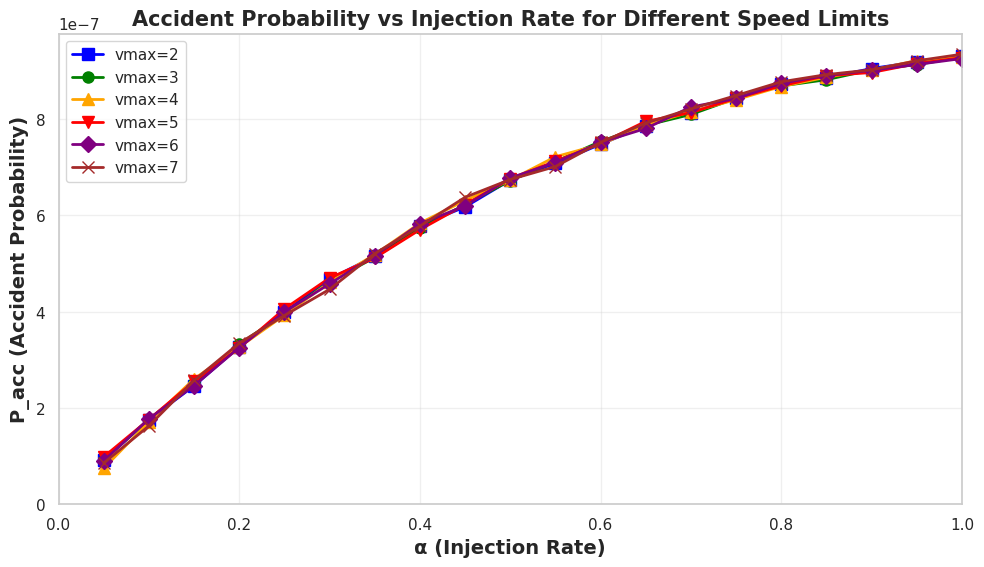

In [7]:
# Create the plot
plt.figure(figsize=(10, 6))

# Define markers and colors for each vmax value
markers = ['s', 'o', '^', 'v', 'D', 'x']
colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown']

# Plot each vmax value as a separate line
for i, vmax in enumerate(vmax_values):
    data = aggregated[aggregated['vmax'] == vmax]
    
    plt.plot(
        data['injection_rate'], 
        data['p_acc_mean'],
        marker=markers[i],
        color=colors[i],
        linestyle='-',
        linewidth=2,
        markersize=8,
        label=f'vmax={vmax}',
        markerfacecolor=colors[i],
        markeredgecolor=colors[i]
    )

# Formatting
plt.xlabel('α (Injection Rate)', fontsize=14, fontweight='bold')
plt.ylabel('P_acc (Accident Probability)', fontsize=14, fontweight='bold')
plt.title('Accident Probability vs Injection Rate for Different Speed Limits', fontsize=15, fontweight='bold')
plt.xlim(0, 1.0)
plt.ylim(bottom=0)
plt.legend(loc='best', frameon=True, fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure
plt.savefig('vmax_accident_plot.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'vmax_accident_plot.png'")

plt.show()

## Create Plot: Throughput vs α for Different vmax Values

This plot shows how throughput varies with injection rate for different maximum velocities.

Plot saved as 'vmax_throughput_plot.png'


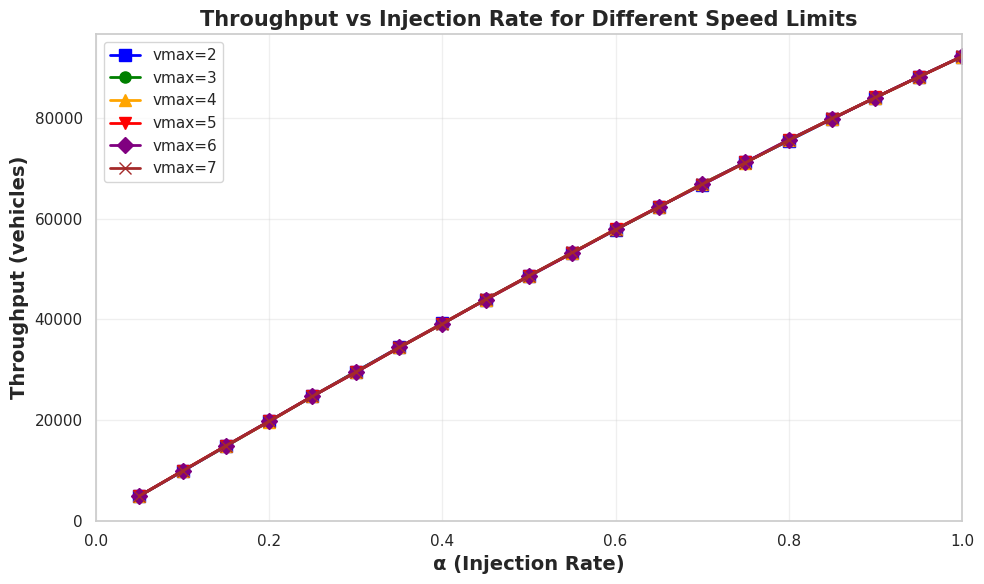

In [8]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot each vmax value as a separate line
for i, vmax in enumerate(vmax_values):
    data = aggregated[aggregated['vmax'] == vmax]
    
    plt.plot(
        data['injection_rate'], 
        data['throughput_mean'],
        marker=markers[i],
        color=colors[i],
        linestyle='-',
        linewidth=2,
        markersize=8,
        label=f'vmax={vmax}',
        markerfacecolor=colors[i],
        markeredgecolor=colors[i]
    )

# Formatting
plt.xlabel('α (Injection Rate)', fontsize=14, fontweight='bold')
plt.ylabel('Throughput (vehicles)', fontsize=14, fontweight='bold')
plt.title('Throughput vs Injection Rate for Different Speed Limits', fontsize=15, fontweight='bold')
plt.xlim(0, 1.0)
plt.ylim(bottom=0)
plt.legend(loc='best', frameon=True, fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure
plt.savefig('vmax_throughput_plot.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'vmax_throughput_plot.png'")

plt.show()

## Create Plot: Average Speed vs α for Different vmax Values

This plot shows how average vehicle speed varies with injection rate for different maximum velocities.

Plot saved as 'vmax_speed_plot.png'


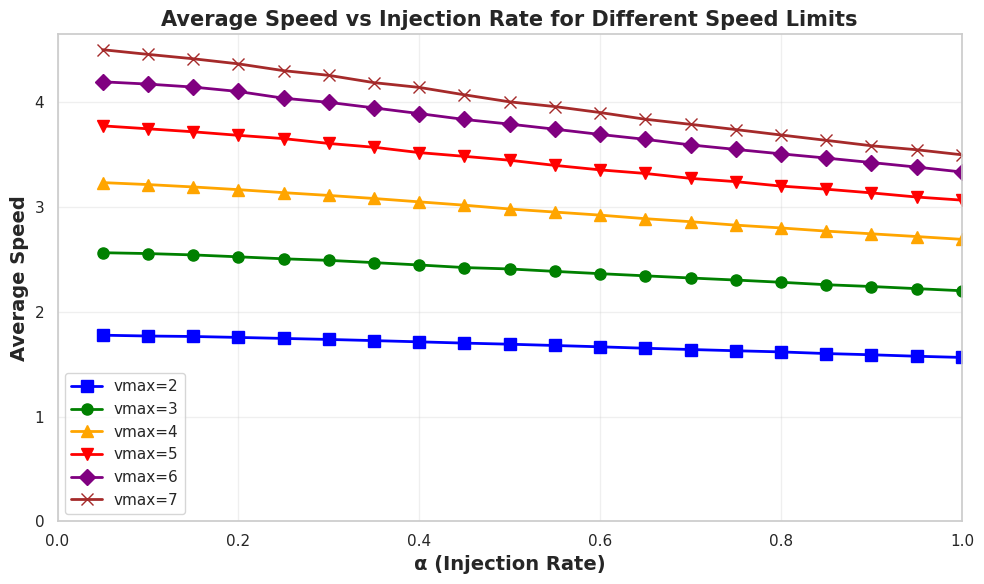

In [9]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot each vmax value as a separate line
for i, vmax in enumerate(vmax_values):
    data = aggregated[aggregated['vmax'] == vmax]
    
    plt.plot(
        data['injection_rate'], 
        data['avg_speed_mean'],
        marker=markers[i],
        color=colors[i],
        linestyle='-',
        linewidth=2,
        markersize=8,
        label=f'vmax={vmax}',
        markerfacecolor=colors[i],
        markeredgecolor=colors[i]
    )

# Formatting
plt.xlabel('α (Injection Rate)', fontsize=14, fontweight='bold')
plt.ylabel('Average Speed', fontsize=14, fontweight='bold')
plt.title('Average Speed vs Injection Rate for Different Speed Limits', fontsize=15, fontweight='bold')
plt.xlim(0, 1.0)
plt.ylim(bottom=0)
plt.legend(loc='best', frameon=True, fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure
plt.savefig('vmax_speed_plot.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'vmax_speed_plot.png'")

plt.show()

## Summary Statistics

Display some key statistics about the results.

In [10]:
# Find peak accident probability for each vmax
print("Peak accident probability (P_acc) for each vmax value:\n")
for vmax in vmax_values:
    data = aggregated[aggregated['vmax'] == vmax]
    max_idx = data['p_acc_mean'].idxmax()
    max_row = data.loc[max_idx]
    
    print(f"vmax = {vmax}:")
    print(f"  Maximum P_acc = {max_row['p_acc_mean']:.6f} at α = {max_row['injection_rate']:.3f}")
    print(f"  Throughput = {max_row['throughput_mean']:.1f}")
    print(f"  Accidents = {max_row['accidents_mean']:.2f}")
    print(f"  Avg Speed = {max_row['avg_speed_mean']:.2f}")
    print()

# Overall statistics
print("\nOverall statistics:")
print(f"Total simulations run: {len(df)}")
print(f"Total unique configurations: {len(aggregated)}")
print(f"Replications per configuration: {REPLICATIONS}")
print(f"Injection rate range: [{injection_rates.min():.2f}, {injection_rates.max():.2f}]")
print(f"vmax values tested: {vmax_values}")

Peak accident probability (P_acc) for each vmax value:

vmax = 2:
  Maximum P_acc = 0.000001 at α = 1.000
  Throughput = 92079.6
  Accidents = 8581.40
  Avg Speed = 1.56

vmax = 3:
  Maximum P_acc = 0.000001 at α = 1.000
  Throughput = 92105.0
  Accidents = 8553.60
  Avg Speed = 2.20

vmax = 4:
  Maximum P_acc = 0.000001 at α = 1.000
  Throughput = 92112.2
  Accidents = 8553.40
  Avg Speed = 2.69

vmax = 5:
  Maximum P_acc = 0.000001 at α = 1.000
  Throughput = 92119.0
  Accidents = 8546.60
  Avg Speed = 3.07

vmax = 6:
  Maximum P_acc = 0.000001 at α = 1.000
  Throughput = 92143.0
  Accidents = 8531.20
  Avg Speed = 3.33

vmax = 7:
  Maximum P_acc = 0.000001 at α = 1.000
  Throughput = 92167.0
  Accidents = 8616.40
  Avg Speed = 3.50


Overall statistics:
Total simulations run: 600
Total unique configurations: 120
Replications per configuration: 5
Injection rate range: [0.05, 1.00]
vmax values tested: [2, 3, 4, 5, 6, 7]


## Comparison: Safety vs Efficiency Trade-off

Analyze the trade-off between throughput (efficiency) and accident probability (safety) for different speed limits.

/tmp/ipykernel_34509/3085842397.py:7: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Plot saved as 'vmax_tradeoff_plot.png'


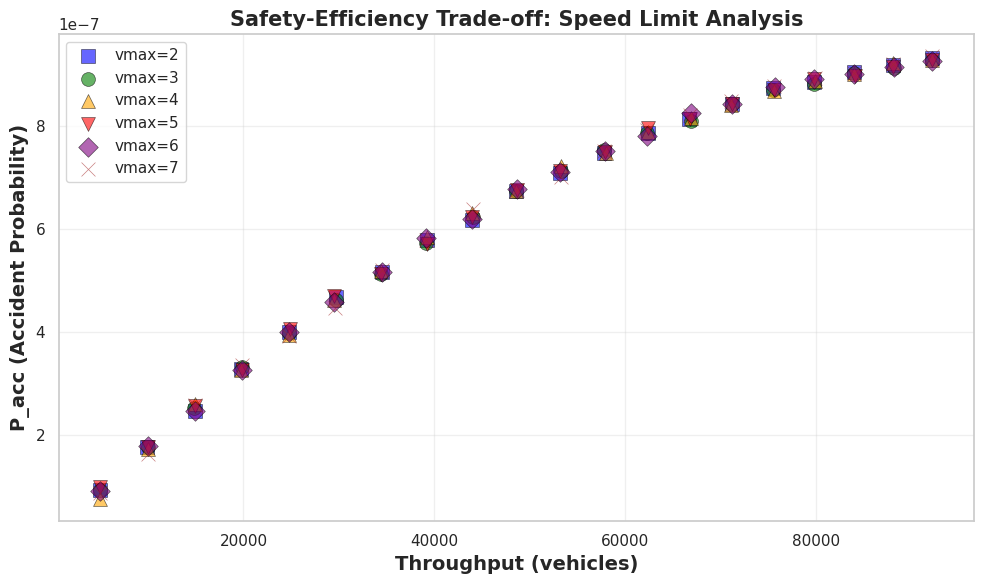

In [11]:
# Create scatter plot: Throughput vs P_acc for each vmax
plt.figure(figsize=(10, 6))

for i, vmax in enumerate(vmax_values):
    data = aggregated[aggregated['vmax'] == vmax]
    
    plt.scatter(
        data['throughput_mean'], 
        data['p_acc_mean'],
        marker=markers[i],
        color=colors[i],
        s=100,
        label=f'vmax={vmax}',
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )

# Formatting
plt.xlabel('Throughput (vehicles)', fontsize=14, fontweight='bold')
plt.ylabel('P_acc (Accident Probability)', fontsize=14, fontweight='bold')
plt.title('Safety-Efficiency Trade-off: Speed Limit Analysis', fontsize=15, fontweight='bold')
plt.legend(loc='best', frameon=True, fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure
plt.savefig('vmax_tradeoff_plot.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'vmax_tradeoff_plot.png'")

plt.show()

## Interpretation

The analysis reveals several key insights about the relationship between speed limits (vmax) and traffic safety:

### Expected Findings:

1. **Speed Limit Effect on Accidents**: Higher speed limits (larger vmax) generally lead to higher accident probabilities, especially at moderate to high injection rates where traffic density is significant but vehicles can still maintain high speeds.

2. **Throughput vs Safety Trade-off**: Higher speed limits may improve throughput at low-to-moderate injection rates, but this comes at the cost of increased accident risk. The optimal speed limit balances these competing objectives.

3. **Saturation Behavior**: At very high injection rates, the difference between speed limits diminishes as congestion forces all vehicles to slow down regardless of vmax.

4. **Critical Speed Threshold**: There may be a critical speed limit above which accident probability increases dramatically without proportional gains in throughput.

5. **Average Speed Patterns**: Average realized speeds will be lower than vmax, especially at high injection rates, showing that posted speed limits don't directly translate to actual speeds in congested conditions.

### Questions to Explore:

- Is there an optimal vmax that maximizes throughput while keeping accident probability below a safety threshold?
- How does the relationship between vmax and accidents change across different traffic density regimes?
- Do lower speed limits provide a "safety margin" that becomes valuable at high densities?
- What is the marginal safety cost of each unit increase in speed limit?